In [314]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sm
import seaborn as sns
from xgboost import XGBRegressor
import my_linear_regression_methods as my_lr
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, ARDRegression
from sklearn.linear_model import Lasso, Ridge, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\ivelk\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [315]:
data = pd.read_csv('task2.txt', sep='\t', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.155051,0.974187,0.074675,0.442146,0.369443,0.468138,0.578846,0.422744,0.931543,0.474148,15
1,0.968379,0.716820,0.678846,0.510049,0.545299,0.573692,0.817491,0.206636,0.880111,0.574187,17
2,0.468263,0.405603,0.320325,0.468084,0.100995,0.974407,0.300062,0.608356,0.050082,0.762011,12
3,0.776820,0.103740,0.373748,0.797782,0.906810,0.599069,0.626680,0.924705,0.632768,0.512663,16
4,0.407886,0.415357,0.101543,0.935160,0.444124,0.193607,0.656837,0.599929,0.868582,0.405406,20


Проверим на наличие пустых элементов

In [316]:
data.isnull().values.any()

False

Описание данных, чтобы понять нужна ли предобработка

In [317]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.490491,0.499785,0.496466,0.503167,0.508902,0.513466,0.487111,0.498870,0.505611,0.499113,15.014000
std,0.293920,0.278833,0.298024,0.284102,0.283300,0.291059,0.288407,0.285954,0.283131,0.284073,4.771223
min,0.000188,0.000085,0.003110,0.001223,0.005314,0.000517,0.000493,0.000408,0.007883,0.000170,3.000000
25%,0.218825,0.262168,0.231492,0.268925,0.274572,0.255524,0.237778,0.256103,0.262332,0.249675,12.000000
50%,0.504439,0.500901,0.484347,0.503412,0.508629,0.527155,0.475274,0.501300,0.518847,0.509422,15.000000
75%,0.738004,0.734516,0.764729,0.747587,0.742461,0.766870,0.738885,0.736849,0.748473,0.741870,18.000000
max,0.999566,0.999959,0.998918,0.998785,0.998478,0.999059,0.999179,0.998646,0.998884,0.998819,29.000000


Признаки имеют одинаковый масштаб, значит для дальнейшей работы нам лучше ненормировать матрицу объекты-признаки.

In [318]:
# Для масштабирования признаков, выше обоснован отказ от этого, т.к. масштаб у них один.
# from sklearn.preprocessing import scale
# from sklearn.utils import shuffle
# df_shuffled = shuffle(data, random_state=123)
# X_s = scale(df_shuffled[df_shuffled.columns[:-1]])
# y_s = df_shuffled[y_index]
# pd.DataFrame(X_s).describe()

In [319]:
# масштабирование признаков незначительно, но увеличило ошибку, работаю дальше с не масштабированными признаками
# means, stds = np.mean(X, axis = 0), np.std(X, axis = 0)
# X_scale = (X - means) / stds
# X_scale_with_ones = np.hstack((X_scale, np.ones((len(X_scale), 1), dtype=float))) # добавляю единичный признак
# print("Cреднеквадратичная ошибка прогноза, если всегда предсказывать медианное значение отклика по исходной выборке: %f\n"  % my_lr.mserror(y, np.median(y) * np.ones(len(y))))
# norm_eq_weights_scale = my_lr.normal_equation(X_scale_with_ones, y)
# print("веса для масштабированных признаков:", norm_eq_weights_scale)
# error_norm_scale = my_lr.mserror(y, my_lr.linear_prediction(X_scale_with_ones, norm_eq_weights_scale))
# print("ср. кв. ошибка по вектору весов масштабированных данных", error_norm_scale)

In [320]:
y_index = data.shape[1] - 1

Посчитаем корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:

In [321]:
data.loc[:,data.columns[:-1]].corrwith(data[y_index])

0    0.429990
1    0.370141
2   -0.008855
3    0.559228
4    0.252266
5   -0.005472
6   -0.028012
7    0.001281
8   -0.018830
9   -0.062788
dtype: float64

In [322]:
data.loc[:,:].corr()

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,-0.030835,0.001454,-0.015437,0.007106,-0.014486,-0.033159,0.007990,-0.013455,-0.007319,0.429990
1,-0.030835,1.000000,0.000963,0.016744,-0.055180,-0.023885,-0.024692,0.008774,0.031948,-0.050875,0.370141
2,0.001454,0.000963,1.000000,0.031122,-0.037663,0.022369,0.016697,0.060331,0.011488,0.013534,-0.008855
3,-0.015437,0.016744,0.031122,1.000000,-0.062312,-0.021409,0.003136,-0.012517,0.001320,-0.042877,0.559228
4,0.007106,-0.055180,-0.037663,-0.062312,1.000000,0.052013,0.024136,0.013285,-0.052652,0.017760,0.252266
5,-0.014486,-0.023885,0.022369,-0.021409,0.052013,1.000000,-0.035630,-0.016145,-0.047458,-0.014605,-0.005472
6,-0.033159,-0.024692,0.016697,0.003136,0.024136,-0.035630,1.000000,0.012450,0.102675,0.013901,-0.028012
7,0.007990,0.008774,0.060331,-0.012517,0.013285,-0.016145,0.012450,1.000000,0.003916,0.045075,0.001281
8,-0.013455,0.031948,0.011488,0.001320,-0.052652,-0.047458,0.102675,0.003916,1.000000,-0.020683,-0.018830
9,-0.007319,-0.050875,0.013534,-0.042877,0.017760,-0.014605,0.013901,0.045075,-0.020683,1.000000,-0.062788


На диагоналях, как и полагается, стоят единицы. И кореллирующих между собой признаков нет.

Построим гистограмму распределения каждого признака из выборки data. 

In [323]:
# [data.plot(y=[x], kind='hist', color='red', title='1') for x in range(y_index)]

Отобразим попарные зависимости признаков. По диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков.

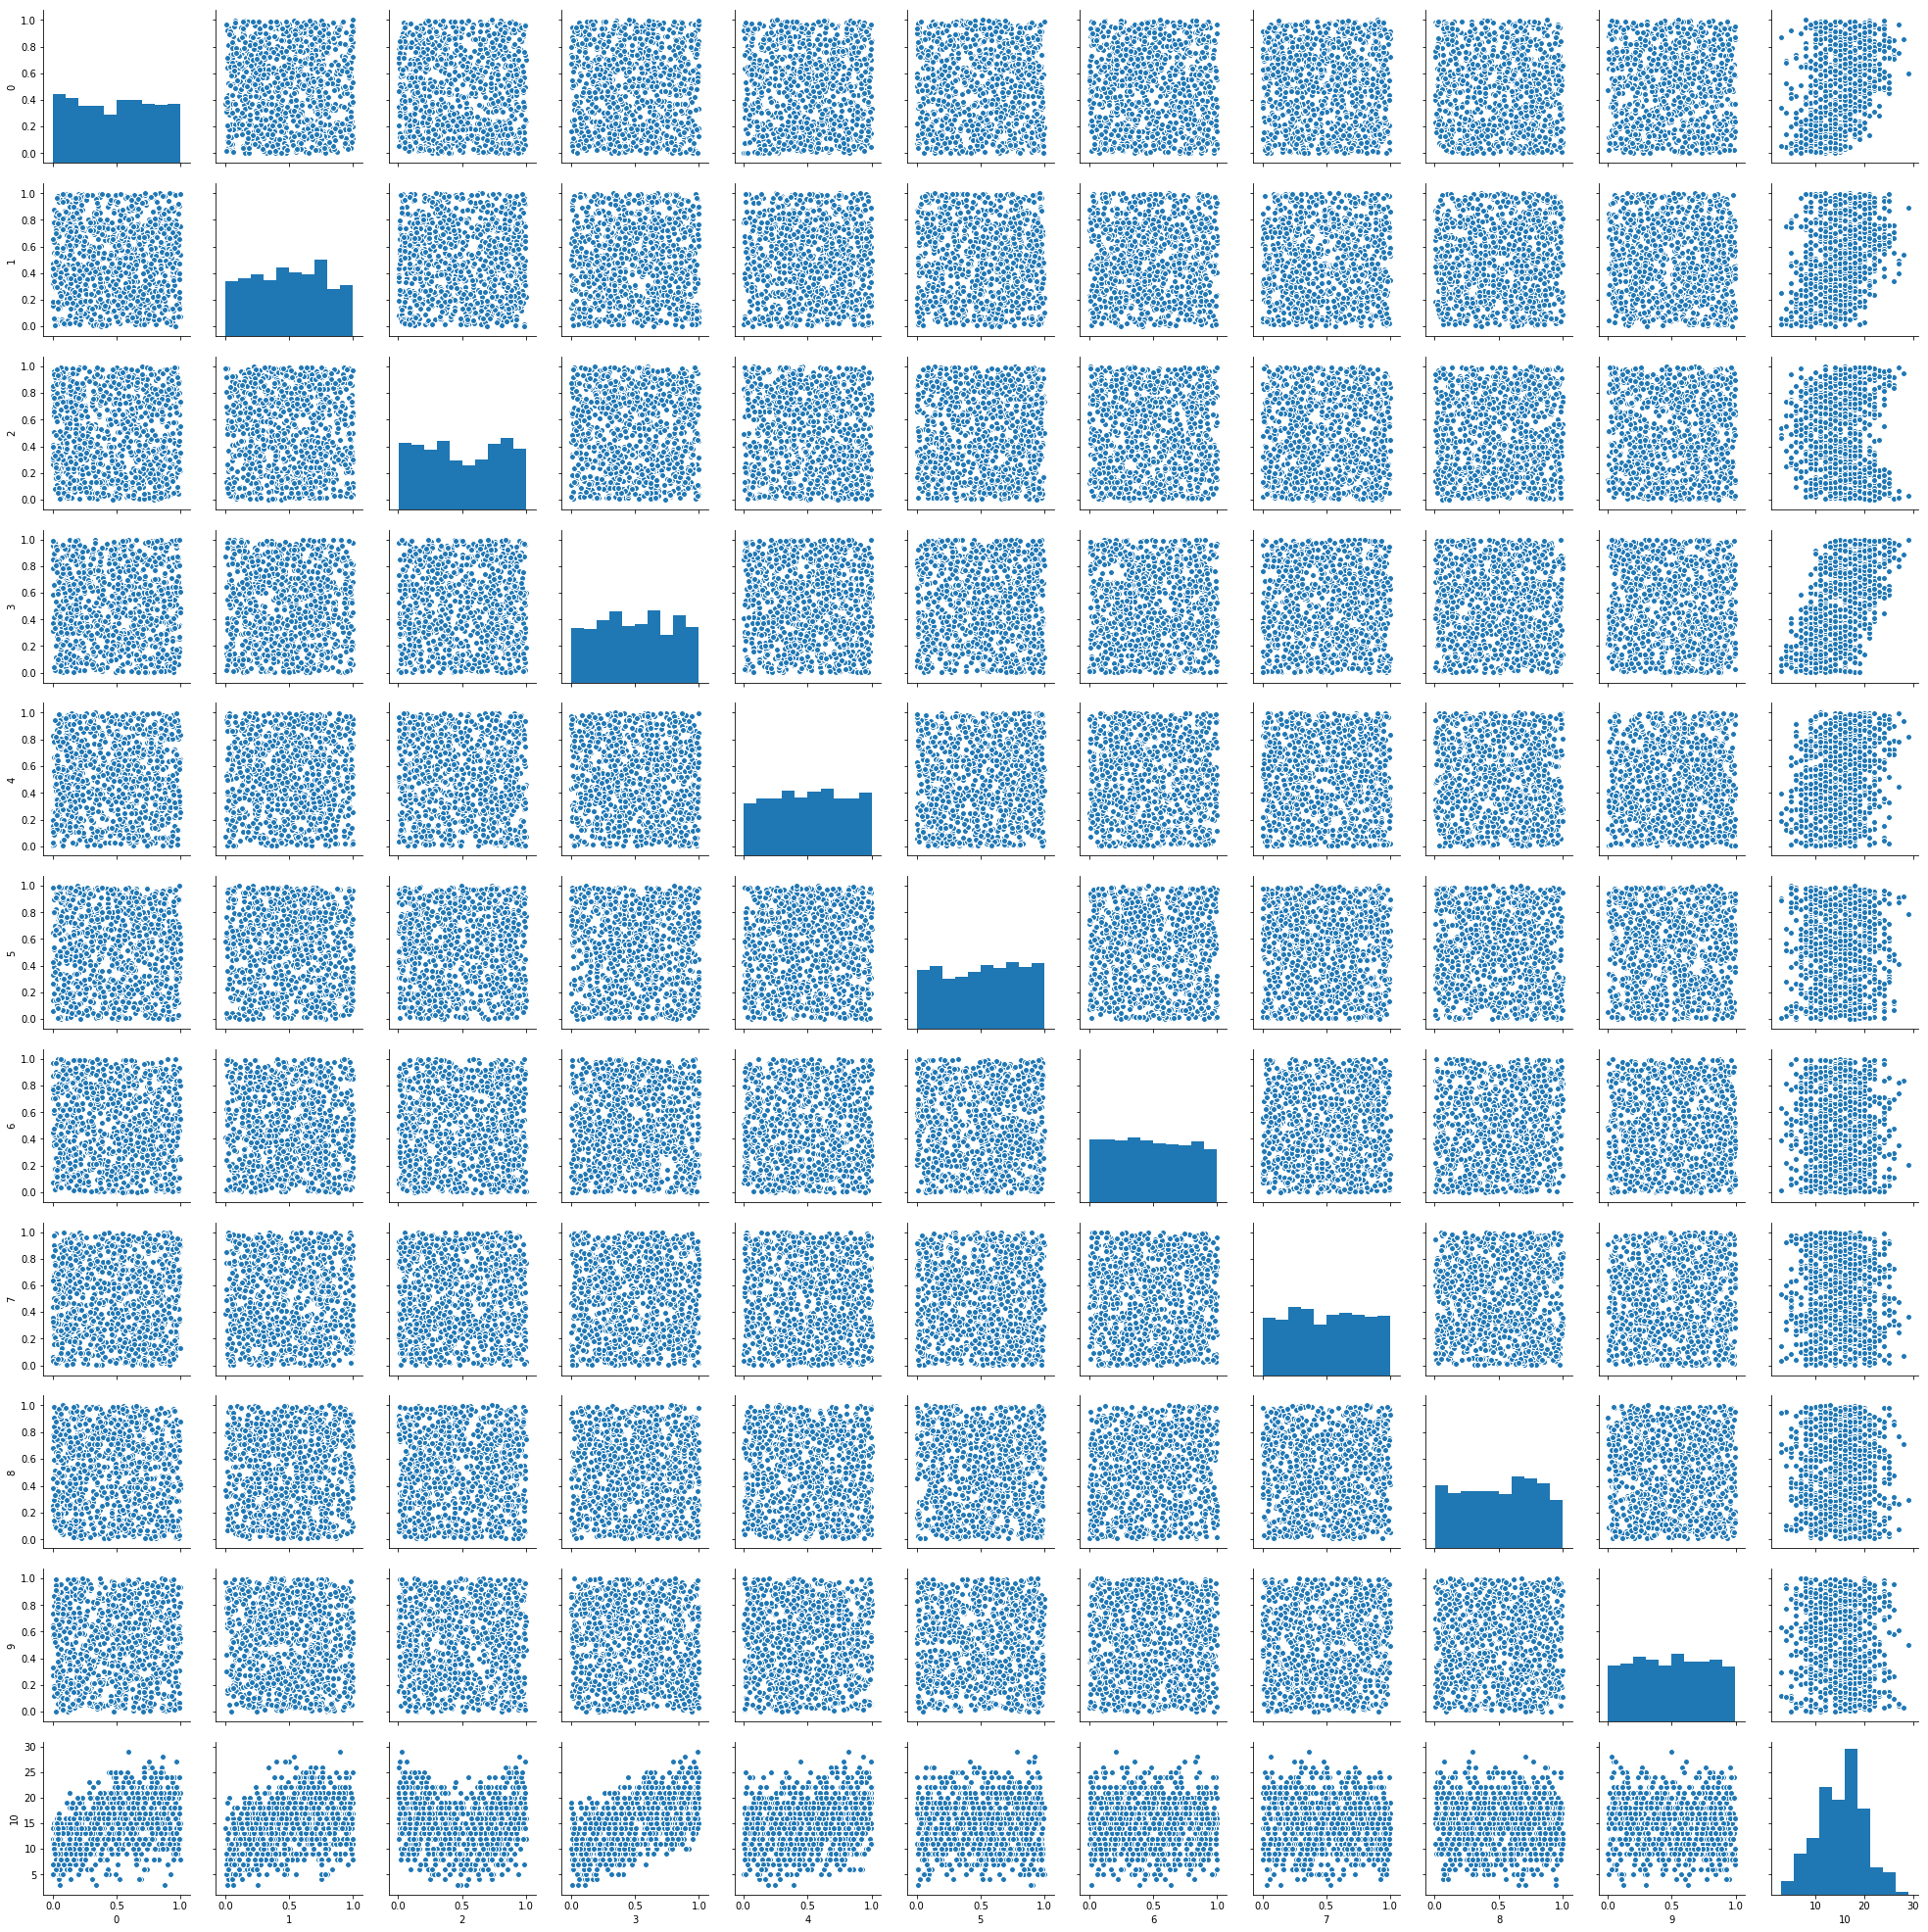

In [324]:
sns.pairplot(data)

Ярко выраженных выбросов в данных нет, как и зависимостей признаков междусобой, что отмечается и корреляцией.
Начиная с 5 признака зависимость похожа на константную, в дальнейшем буду обучать и сравнивать модели как на всех признаках, так и на первых 5 только.

In [325]:
X, y = data.values[:, :-1], data.values[:, -1]

Посмотрим на распределение ответов

In [326]:
# Counter(data[y_index])
# data.groupby(y_index)[y_index].count()

Text(0.5,0,'10 column')

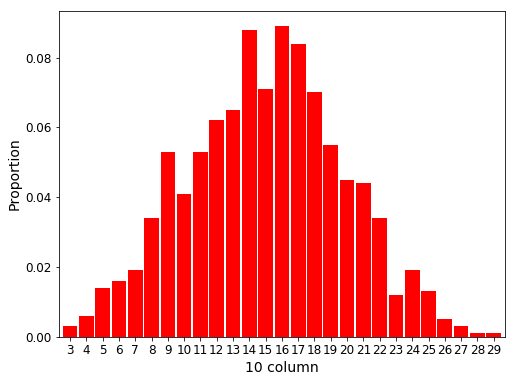

In [327]:
plt.figure(figsize(8,6))
stat = data.groupby(y_index)[y_index].agg(lambda x : float(len(x)) / data.shape[0])
stat.plot(kind='bar', fontsize=12, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel(str(y_index) + ' column', fontsize=14)

Распределение ответов похоже на нормальное, поэтому буду решать задачу регресии 

# 1 Линейная регрессия и стохастический градиентный спуск

Добавляю единичный признак

In [328]:
X_with_ones = np.hstack((X, np.ones((len(X), 1), dtype=float)))

Функция mserror - среднеквадратичная ошибка прогноза. Она принимает два аргумента - объекты Series y (значения целевого признака) и y_pred (предсказанные значения).

Cреднеквадратичная ошибка прогноза, если всегда предсказывать медианное значение отклика по исходной выборке:

In [329]:
mean_squared_error(y, np.median(y) * np.ones(len(y)))

22.742

Функция normal_equation, которая по заданным матрицам (массивам NumPy) X и y вычисляет вектор весов w согласно нормальному уравнению линейной регрессии

In [330]:
norm_eq_weights = my_lr.normal_equation(X_with_ones, y)
print('Веса:',  norm_eq_weights)
error_norm = mean_squared_error(y, my_lr.linear_prediction(X_with_ones, norm_eq_weights))
print('Среднеквадратичная ошибка:', error_norm)

Веса: [ 7.27672965e+00  6.67876858e+00 -2.54862788e-01  9.71509423e+00
  5.15213723e+00  9.94432729e-02 -1.82749998e-01 -6.96572954e-03
 -1.47143689e-01 -3.35640844e-01  1.00651769e+00]
Среднеквадратичная ошибка: 5.9189530811166415


In [331]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = my_lr.stochastic_gradient_descent(X_with_ones, y, np.zeros((X_with_ones.shape[1],1)), eta=1e-2, max_iter=1e5, min_weight_dist=1e-8, seed=0, verbose=True)

Iteration:  0
Iteration:  10000
Iteration:  20000
Iteration:  30000
Wall time: 7.24 s


Посмотрим, чему равна ошибка на первых 50 итерациях стохастического градиентного спуск.

Text(0,0.5,'MSE')

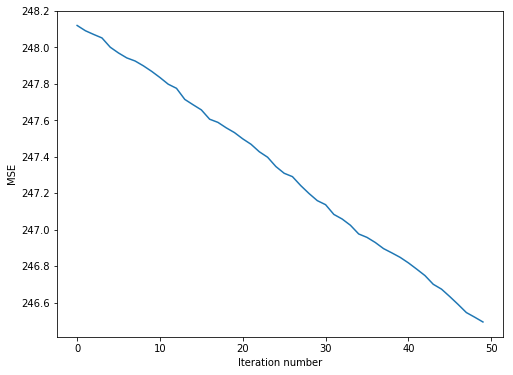

In [332]:
plt.plot(range(50), list(stoch_errors_by_iter[:50]))
xlabel('Iteration number')
ylabel('MSE')

Теперь посмотрим на зависимость ошибки от номера итерации для $10^5$ итераций стохастического градиентного спуска. Видим, что алгоритм сходится.

Text(0,0.5,'MSE')

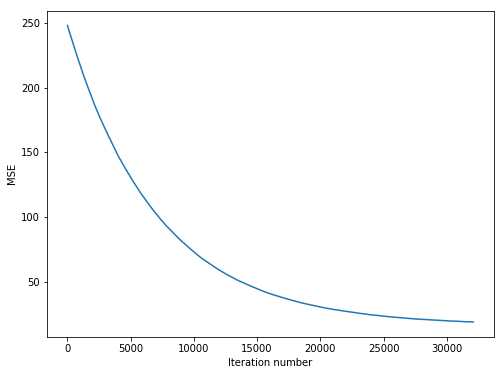

In [333]:
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

Посмотрим на вектор весов, к которому сошелся метод и сравним его с вектором весов из аналитического решения

In [334]:
stoch_grad_desc_weights.squeeze(), norm_eq_weights

(array([2.16243792, 2.13493462, 1.7870565 , 2.31925976, 2.06878176,
        1.85861231, 1.7580726 , 1.81267619, 1.82868874, 1.76777207,
        3.78030669]),
 array([ 7.27672965e+00,  6.67876858e+00, -2.54862788e-01,  9.71509423e+00,
         5.15213723e+00,  9.94432729e-02, -1.82749998e-01, -6.96572954e-03,
        -1.47143689e-01, -3.35640844e-01,  1.00651769e+00]))

In [335]:
mean_squared_error(y, np.dot(X_with_ones, stoch_grad_desc_weights)), error_norm

(18.939777518866748, 5.9189530811166415)

Видим, что среднеквадратичная ошибка при весах полученных стохастическим градиентным спуском больше, чем при аналитическом решении. И такое бывает! Скорее всего зависимость нелинейная, но поанализируем еще немножко, чтобы было с чем сравнивать! 

# 2

In [336]:
linear_regressor = LinearRegression()
linear_regressor.fit(X,y)
print ("признак -> коэффициент\n")
for pair in zip(data.columns, linear_regressor.coef_):
    print (pair)
print("\nкоэффициент детерминации:", linear_regressor.score(X, y))

признак -> коэффициент

(0, 7.276729650802521)
(1, 6.678768582731815)
(2, -0.2548627876882644)
(3, 9.715094233593186)
(4, 5.15213722689206)
(5, 0.0994432728901362)
(6, -0.18274999773977432)
(7, -0.0069657295428111835)
(8, -0.14714368903535546)
(9, -0.33564084403844013)

коэффициент детерминации: 0.7397324732410568


In [337]:
# Обучим линейную модель с L1-регуляризацией и выведим веса
lasso_regressor = Lasso()
lasso_regressor.fit(X,y)
print ("признак -> коэффициент\n")
for pair in zip(data.columns, lasso_regressor.coef_):
    print (pair)
print("\nкоэффициент детерминации:", lasso_regressor.score(X, y))

признак -> коэффициент

(0, 0.0)
(1, 0.0)
(2, -0.0)
(3, 0.0)
(4, 0.0)
(5, -0.0)
(6, -0.0)
(7, 0.0)
(8, -0.0)
(9, -0.0)

коэффициент детерминации: 0.0


Весы Lasso нулевые при очень большом alpha. Чем больше alpha, тем ниже сложность модели, т.е. меньше признаков участвуют в построении. Самая простая модель константа, т.е. ни один признак не участвует -> все веса равны нулю. alpha = 1. При alpha = 0 получаем веса как в модели линейной регрессии.

In [338]:
# Обучим линейную модель с L1-регуляризацией и выведим веса
lasso_regressor = Lasso(alpha=0.)
lasso_regressor.fit(X,y)
print ("признак -> коэффициент\n")
for pair in zip(data.columns, lasso_regressor.coef_):
    print (pair)
print("\nкоэффициент детерминации:", lasso_regressor.score(X, y))

признак -> коэффициент

(0, 7.276729650802525)
(1, 6.678768582731813)
(2, -0.2548627876882671)
(3, 9.71509423359318)
(4, 5.15213722689207)
(5, 0.09944327289012775)
(6, -0.18274999773978204)
(7, -0.006965729542833787)
(8, -0.147143689035341)
(9, -0.33564084403843153)

коэффициент детерминации: 0.7397324732410568


C:\Users\ivelk\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Значит нам нужно выбрать наилучшее alpha на отрезке [0, 1]. 

Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.
И делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией. 

C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha = 0.014000

признак -> коэффициент

'0tr' -> 7.113339
'1tr' -> 6.490305
'2tr' -> -0.101807
'3tr' -> 9.529554
'4tr' -> 4.969720
'5tr' -> 0.000000
'6tr' -> -0.042653
'7tr' -> -0.000000
'8tr' -> -0.000000
'9tr' -> -0.180275


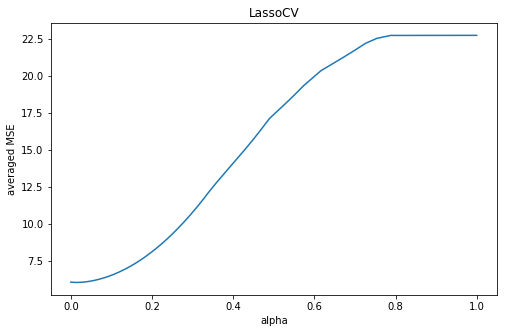

In [339]:
alphas = np.arange(0., 1., 0.0005)
lasso_regressor_CV = LassoCV(alphas=alphas, cv=3)
lasso_regressor_CV.fit(X,y)

plt.figure(figsize=(8, 5))
plt.plot(lasso_regressor_CV.alphas_, lasso_regressor_CV.mse_path_.mean(axis = 1))
plt.xlabel("alpha")
plt.ylabel("averaged MSE")
plt.title("LassoCV")
print ("alpha = %f\n"  % (lasso_regressor_CV.alpha_))
print ("признак -> коэффициент\n")
for pr, w in zip(data.columns[:-1], lasso_regressor_CV.coef_):
    print ("'%str' -> %f" % (pr, w))

alphas_min -> mse_argmin
0.000000 -> 6.226005
0.018500 -> 6.077606
0.031000 -> 5.776001


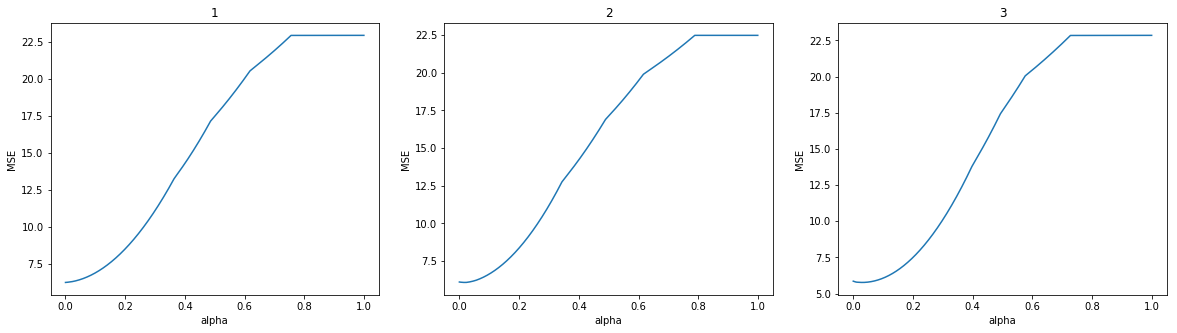

In [340]:
# Выведим значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
print ("alphas_min -> mse_argmin")
for a, mse_min in zip(lasso_regressor_CV.alphas_[np.argmin(lasso_regressor_CV.mse_path_, axis = 0)],lasso_regressor_CV.mse_path_.min(axis = 0)):
    print("%f -> %f" % (a, mse_min))

plt.rcParams['figure.figsize'] = 20, 5

iter = 1
while (iter<=3):
    plt.subplot(1,3,iter)
    plt.plot(lasso_regressor_CV.alphas_, lasso_regressor_CV.mse_path_[:,iter-1])
    plt.title(iter)
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    iter+=1

In [341]:
lasso_regressor = Lasso(0.014)
lasso_regressor.fit(X,y)
for pair in zip(data.columns, lasso_regressor.coef_):
    print (pair)
lasso_regressor.score(X, y)

(0, 7.113338888297954)
(1, 6.490304724539254)
(2, -0.10180746931423623)
(3, 9.529554014134044)
(4, 4.969719618104957)
(5, 0.0)
(6, -0.04265308807987291)
(7, -0.0)
(8, -0.0)
(9, -0.18027533573022722)


0.7388838092650967

In [342]:
# Обучим линейную модель с L2-регуляризацией и выведим веса
ridge_regressor = Ridge()
ridge_regressor.fit(X,y)
for pair in zip(data.columns, ridge_regressor.coef_):
    print (pair)
ridge_regressor.score(X, y)

(0, 7.189320415783032)
(1, 6.588648827303566)
(2, -0.25072821593909045)
(3, 9.591163179668708)
(4, 5.077236703840008)
(5, 0.09596338047498022)
(6, -0.18356879161765238)
(7, -0.0060356775698830615)
(8, -0.1477097334604543)
(9, -0.3407174867253974)


0.7396097686544687

In [343]:
ridge_regressor = Ridge(alpha=0.014)
ridge_regressor.fit(X,y)
for pair in zip(data.columns, ridge_regressor.coef_):
    print (pair)
ridge_regressor.score(X, y)

(0, 7.275491150005971)
(1, 6.677489793221216)
(2, -0.2548040535967832)
(3, 9.713336948160054)
(4, 5.1510736261661885)
(5, 0.099393576411751)
(6, -0.1827620415577443)
(7, -0.00695230816146074)
(8, -0.14715219168514507)
(9, -0.3357144894676152)


0.739732448561754

# 3

Научимся оценивать ответы. Отделим 25% выборки для контроля качества предсказания:

In [344]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns[:-1]], data[data.columns[-1]], test_size=0.3)
print("среднее значение отклика обучающей выборки: %f" % np.mean(y_train))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test)))

среднее значение отклика обучающей выборки: 15.077143
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 4.667185
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 4.999319


## Линейная регрессия

In [345]:
lm = LinearRegression()
lm.fit(X_train, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(lm.predict(X_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(lm.predict(X_train), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(lm.predict(X_test), y_test)))
print('коэффициент детерминации: %f' % lm.score(X_test, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, lm.predict(X_test)))

среднее значение отклика обучающей выборки: 15.077143
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 2.300538
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.740427
коэффициент детерминации: 0.698987
абсолютная ошибка: 2.053786


In [346]:
print (list(np.array(y_test)[:10]))
print (list(map(lambda x: int(round(x)), (lm.predict(X_test))[:10])))

[12, 13, 22, 9, 10, 9, 19, 6, 14, 25]
[12, 13, 19, 10, 14, 12, 14, 7, 15, 23]


## SGD регрессия

In [347]:
sgd = SGDRegressor(random_state = 0, max_iter = 100)
sgd.fit(X_train, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(sgd.predict(X_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(sgd.predict(X_train), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(sgd.predict(X_test), y_test)))
print('коэффициент детерминации: %f' % sgd.score(X_test, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, sgd.predict(X_test)))

среднее значение отклика обучающей выборки: 15.113592
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 2.309266
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.746968
коэффициент детерминации: 0.697548
абсолютная ошибка: 2.080748


In [348]:
sgd.get_params().keys()

dict_keys(['alpha', 'average', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'verbose', 'warm_start'])

In [349]:
parameters_grid = {
    'max_iter' : [3, 10, 50, 100], 
    'penalty' : ['l1', 'l2', 'none'],
    'alpha' : [0., 0.01, 0.014, 0.1],
}

In [350]:
grid_cv = GridSearchCV(sgd, parameters_grid, scoring = 'mean_absolute_error', cv = 4)

In [351]:
%%time
grid_cv.fit(X_train, y_train)

C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3

C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3

C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3

C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3

Wall time: 1.25 s


C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\ivelk\Anaconda3

GridSearchCV(cv=4, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=100, n_iter=None, penalty='l2',
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_iter': [3, 10, 50, 100], 'penalty': ['l1', 'l2', 'none'], 'alpha': [0.0, 0.01, 0.014, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [352]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

-1.852729734626201
{'alpha': 0.0, 'max_iter': 100, 'penalty': 'l1'}


In [353]:
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(grid_cv.best_estimator_.predict(X_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(grid_cv.best_estimator_.predict(X_train), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(grid_cv.best_estimator_.predict(X_test), y_test)))
print('коэффициент детерминации: %f' % grid_cv.best_estimator_.score(X_test, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, grid_cv.best_estimator_.predict(X_test)))

среднее значение отклика обучающей выборки: 15.113686
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 2.309024
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.746869
коэффициент детерминации: 0.697570
абсолютная ошибка: 2.080196


In [354]:
print (list(np.array(y_test)[:10]))
print (list(map(lambda x: int(round(x)), (grid_cv.best_estimator_.predict(X_test))[:10])))

[12, 13, 22, 9, 10, 9, 19, 6, 14, 25]
[12, 13, 19, 10, 13, 12, 14, 7, 15, 23]


(-10, 50)

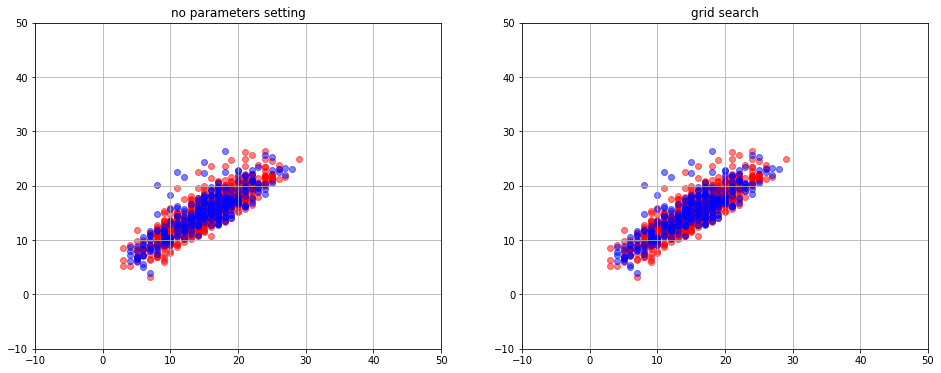

In [355]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(y_train, sgd.predict(X_train), alpha=0.5, color = 'red')
pylab.scatter(y_test, sgd.predict(X_test), alpha=0.5, color = 'blue')
pylab.title('no parameters setting')
pylab.xlim(-10,50)
pylab.ylim(-10,50)

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(y_train, grid_cv.best_estimator_.predict(X_train), alpha=0.5, color = 'red')
pylab.scatter(y_test, grid_cv.best_estimator_.predict(X_test), alpha=0.5, color = 'blue')
pylab.title('grid search')
pylab.xlim(-10,50)
pylab.ylim(-10,50)

## ARD регрессия

In [356]:
ard = ARDRegression()
ard.fit(X_train, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(ard.predict(X_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(ard.predict(X_train), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(ard.predict(X_test), y_test)))
print('коэффициент детерминации: %f' % ard.score(X_test, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, ard.predict(X_test)))

среднее значение отклика обучающей выборки: 15.077143
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 2.302826
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.733396
коэффициент детерминации: 0.700530
абсолютная ошибка: 2.046111


In [357]:
print (list(np.array(y_test)[:10]))
print (list(map(lambda x: int(round(x)), (ard.predict(X_test))[:10])))

[12, 13, 22, 9, 10, 9, 19, 6, 14, 25]
[12, 14, 20, 10, 14, 11, 14, 7, 15, 23]


## Случайный лес

Построим на обучающей выборке случайный лес:

In [358]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)
rf.fit(X_train, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(rf.predict(X_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print('коэффициент детерминации: %f' % rf.score(X_test, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, rf.predict(X_test)))

среднее значение отклика обучающей выборки: 15.049629
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 0.909693
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.060640
коэффициент детерминации: 0.829803
абсолютная ошибка: 1.579129


In [359]:
print (list(np.array(y_test)[:10]))
print (list(map(lambda x: int(round(x)), (rf.predict(X_test))[:10])))

[12, 13, 22, 9, 10, 9, 19, 6, 14, 25]
[14, 12, 22, 12, 10, 9, 17, 8, 14, 22]


(-10, 50)

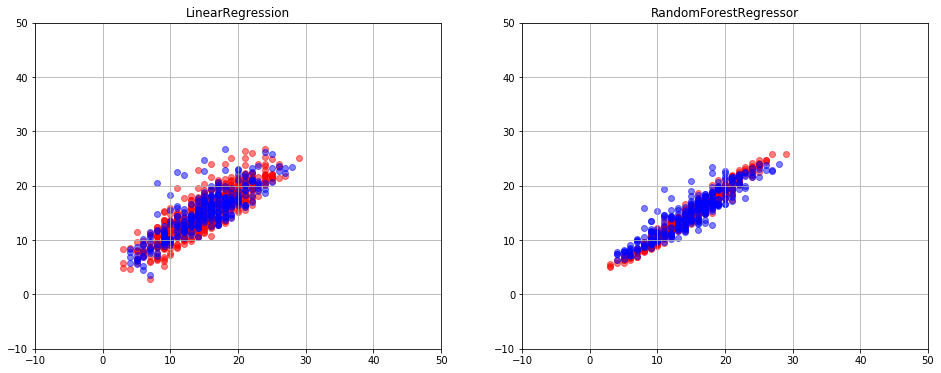

In [360]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(y_train, lm.predict(X_train), alpha=0.5, color = 'red')
pylab.scatter(y_test, lm.predict(X_test), alpha=0.5, color = 'blue')
pylab.title('LinearRegression')
pylab.xlim(-10,50)
pylab.ylim(-10,50)

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(y_train, rf.predict(X_train), alpha=0.5, color = 'red')
pylab.scatter(y_test, rf.predict(X_test), alpha=0.5, color = 'blue')
pylab.title('RandomForestRegressor')
pylab.xlim(-10,50)
pylab.ylim(-10,50)

Сравним ошибки линейной регрессии и случайного леса на тестовой выборке:

Text(0.5,0,'Difference of absolute errors')

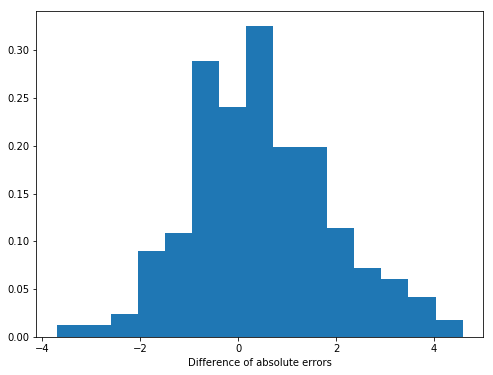

In [361]:
plt.figure(figsize(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15, normed=True)
plt.xlabel('Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [362]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))
print('Средняя разность абсолютных ошибок: %f' % np.mean(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test))))
tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

Средняя разность абсолютных ошибок: 0.474657


0.00028052640783806396

95% доверительный интервал для средней разности абсолютных ошибок:

In [363]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.21956271460318816, 0.7297516369252268)

Посмотрим, какие признаки обладают наибольшей предсказательной способностью:

In [364]:
importances = pd.DataFrame([[k, l] for k, l in zip(X_train.columns, rf.feature_importances_)])
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
3,3,0.354763
0,0,0.261791
1,1,0.222929
4,4,0.081053
2,2,0.038432
9,9,0.009262
5,5,0.008543
6,6,0.007968
8,8,0.007659
7,7,0.007599


Cильнее всего на ответ влияет признак 3, записанный в 4 ом столбце

# 4

Наименее значимые 5, 6, 7, 8 признаки попробуем исключить 5, 7, 8 так как их зануляет и l1 регуляризатор в линейной регрессии

In [365]:
X_train_new, X_test_new =  X_train.loc[:, [0, 1, 2, 3, 4, 6, 9]], X_test.loc[:, [0, 1, 2, 3, 4, 6, 9]]

In [366]:
lm_h = LinearRegression()
lm_h.fit(X_train_new, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(lm_h.predict(X_train_new)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(lm_h.predict(X_train_new), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(lm_h.predict(X_test_new), y_test)))
print('коэффициент детерминации: %f' % lm_h.score(X_test_new, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, lm_h.predict(X_test_new)))

среднее значение отклика обучающей выборки: 15.077143
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 2.301911
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.735725
коэффициент детерминации: 0.700019
абсолютная ошибка: 2.048344


In [367]:
sgd_h = SGDRegressor(random_state = 0, max_iter = 100)
sgd_h.fit(X_train_new, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(sgd_h.predict(X_train_new)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(sgd_h.predict(X_train_new), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(sgd_h.predict(X_test_new), y_test)))
print('коэффициент детерминации: %f' % sgd_h.score(X_test_new, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, sgd_h.predict(X_test_new)))

среднее значение отклика обучающей выборки: 15.117945
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 2.312765
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.739336
коэффициент детерминации: 0.699227
абсолютная ошибка: 2.077806


In [368]:
ard_h = ARDRegression()
ard_h.fit(X_train_new, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(ard_h.predict(X_train_new)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(ard_h.predict(X_train_new), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(ard_h.predict(X_test_new), y_test)))
print('коэффициент детерминации: %f' % ard_h.score(X_test_new, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, ard_h.predict(X_test_new)))

среднее значение отклика обучающей выборки: 15.077143
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 2.302847
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.733374
коэффициент детерминации: 0.700534
абсолютная ошибка: 2.046079


In [369]:
rf_h = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)
rf_h.fit(X_train_new, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(rf_h.predict(X_train_new)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(rf_h.predict(X_train_new), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(rf_h.predict(X_test_new), y_test)))
print('коэффициент детерминации: %f' % rf_h.score(X_test_new, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, rf_h.predict(X_test_new)))

среднее значение отклика обучающей выборки: 15.049504
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 0.906528
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.012705
коэффициент детерминации: 0.837629
абсолютная ошибка: 1.530593


# 5

случайный лес для сравнения

среднее значение отклика обучающей выборки: 15.049629

корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 0.909693

корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 2.060640

коэффициент детерминации: 0.829803

абсолютная ошибка: 1.579129

In [370]:
gb = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=3)
gb.fit(X_train, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(gb.predict(X_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(gb.predict(X_train), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(gb.predict(X_test), y_test)))
print('коэффициент детерминации: %f' % gb.score(X_test, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, gb.predict(X_test)))

среднее значение отклика обучающей выборки: 15.077143
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 0.566794
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 1.311498
коэффициент детерминации: 0.931058
абсолютная ошибка: 0.932137


In [414]:
gb_importances = pd.DataFrame([[k, l] for k, l in zip(X_train.columns, gb.feature_importances_)])
gb_importances.columns = ['feature name', 'importance']
gb_importances.sort_values(by='importance', ascending=False)

,feature name,importance
2,2,0.235812
1,1,0.208087
0,0,0.195737
3,3,0.191140
4,4,0.125804
6,6,0.013920
8,8,0.010942
7,7,0.010588
9,9,0.006478
5,5,0.001491


In [371]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
np.random.seed(0)
print("среднее значение отклика обучающей выборки: %f" % np.mean(xgb.predict(X_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: %f" % sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print("корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: %f" % sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print('коэффициент детерминации: %f' % xgb.score(X_test, y_test))
print('абсолютная ошибка: %f' % mean_absolute_error(y_test, xgb.predict(X_test)))

среднее значение отклика обучающей выборки: 15.077553
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, обучение: 0.560707
корень из среднеквадратичной ошибки прогноза средним значением на обучающей выборке, тест: 1.295201
коэффициент детерминации: 0.932761
абсолютная ошибка: 0.924901


In [372]:
print (list(np.array(y_test)[50:60]))
print (list(map(lambda x: int(round(x)), (xgb.predict(X_test))[50:60])))

[12, 23, 18, 19, 23, 13, 11, 14, 19, 13]
[13, 21, 18, 18, 20, 13, 12, 14, 18, 15]


In [376]:
xgb_importances = pd.DataFrame([[k, l] for k, l in zip(X_train.columns, xgb.feature_importances_)])
xgb_importances.columns = ['feature name', 'importance']
xgb_importances.sort_values(by='importance', ascending=False)

,feature name,importance
0,0,0.220779
1,1,0.213564
2,2,0.189033
3,3,0.160173
4,4,0.135642
7,7,0.028860
6,6,0.020202
5,5,0.014430
8,8,0.010101
9,9,0.007215


(0, 30)

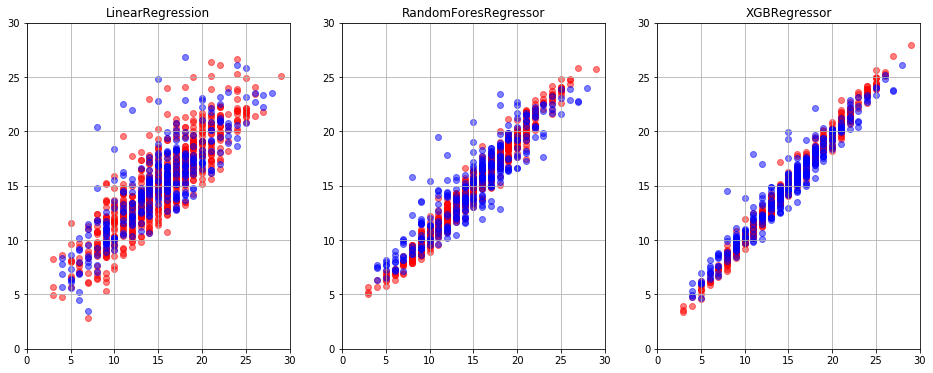

In [373]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,3,1)
pylab.grid(True)
pylab.scatter(y_train, lm.predict(X_train), alpha=0.5, color = 'red')
pylab.scatter(y_test, lm.predict(X_test), alpha=0.5, color = 'blue')
pylab.title('LinearRegression')
pylab.xlim(0,30)
pylab.ylim(0,30)

pylab.subplot(1,3,2)
pylab.grid(True)
pylab.scatter(y_train, rf.predict(X_train), alpha=0.5, color = 'red')
pylab.scatter(y_test, rf.predict(X_test), alpha=0.5, color = 'blue')
pylab.title('RandomForesRegressor')
pylab.xlim(0,30)
pylab.ylim(0,30)

pylab.subplot(1,3,3)
pylab.grid(True)
pylab.scatter(y_train, xgb.predict(X_train), alpha=0.5, color = 'red')
pylab.scatter(y_test, xgb.predict(X_test), alpha=0.5, color = 'blue')
pylab.title('XGBRegressor')
pylab.xlim(0,30)
pylab.ylim(0,30)

Сравним ошибки линейной регрессии и градиентного бустинга на тестовой выборке:

Text(0.5,0,'Difference of absolute errors')

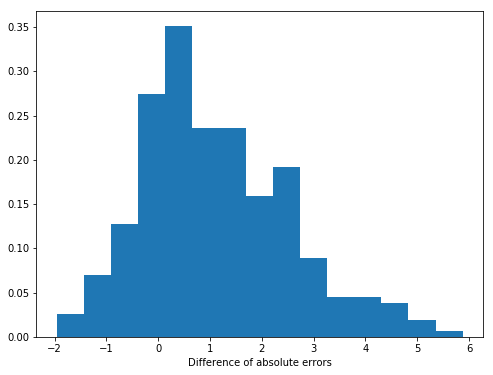

In [416]:
plt.figure(figsize(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - xgb.predict(X_test)), bins=15, normed=True)
plt.xlabel('Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [418]:
tmeans_lm_xgb = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - xgb.predict(X_test))))
print('Средняя разность абсолютных ошибок: %f' % np.mean(abs(y_test - lm.predict(X_test)) - abs(y_test - xgb.predict(X_test))))
tmeans_lm_xgb.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

Средняя разность абсолютных ошибок: 1.128885


1.762896329346422e-20

95% доверительный интервал для средней разности абсолютных ошибок:

In [419]:
tmeans_lm_xgb.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.8985158187264567, 1.3592547019316599)

Сравним ошибки случайного леса и градиентного бустинга на тестовой выборке:

Text(0.5,0,'Difference of absolute errors')

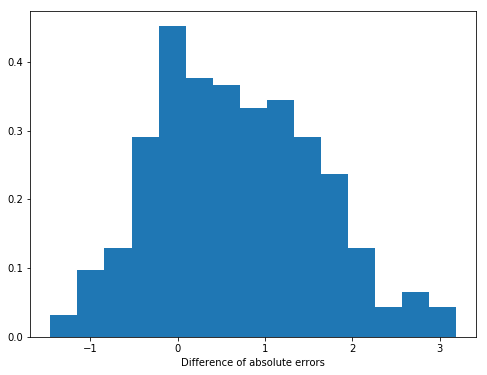

In [421]:
plt.figure(figsize(8,6))
plt.hist(abs(y_test - rf.predict(X_test)) - abs(y_test - xgb.predict(X_test)), bins=15, normed=True)
plt.xlabel('Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [422]:
tmeans_rf_xgb = sm.CompareMeans(sm.DescrStatsW(abs(y_test - rf.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - xgb.predict(X_test))))
print('Средняя разность абсолютных ошибок: %f' % np.mean(abs(y_test - rf.predict(X_test)) - abs(y_test - xgb.predict(X_test))))
tmeans_rf_xgb.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

Средняя разность абсолютных ошибок: 0.654228


4.946986367750002e-12

95% доверительный интервал для средней разности абсолютных ошибок:

In [423]:
tmeans_rf_xgb.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.4719833643651036, 0.8364728047645981)

**Как по коэффициенту детерминации, так и по среднеквадратичной ошибке однозначно лучшей моделью является градиентный бустинг, в частности, его реализация в пакете xgboost.**

**Наибольшей предсказательной способностью согласно моделям линейной регрессии и случайного леса обладает 3 признак, если нумерация начинается с 0.**

**Согласно лучшей по метрикам качества модели градиентного бустинга наибольшей предсказательной способностью обладает признак под номером 0, для реализации модели из пакета xgboost.**

**В то время как для модели градиентного бустинга из пакета sklearn наибольшей предсказательной способностью обладает признак под номером 2.** 
